In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

## Cleaning Data
The cell below is used to remove movies which for one reason or another do not lend themselves to analysis. For instance we've decided to discard movies which were in theaters for fewer than 4 weeks.

In [2]:
boxOffice = pickle.load( open( "BoxOfficeMojoWeekly.p", "rb" ) )
rawBoxOffice = pickle.load( open( "BoxOfficeMojoWeekly.p", "rb" ) )
titles = list(boxOffice.keys())
stringVal = False
badOrder = 0
for title in titles:
    movieData = boxOffice[title]
    # Remove entries with no weekly gross data, number of theaters, or with fewer than three reported weeks
    if ('Weekly' not in movieData.columns) or ('-' in movieData.Theaters.values) or (int(max(movieData.Week))<=3) or (movieData.Week.iloc[0]!=1):
        del boxOffice[title]
    # A few movies have special opening weekends which open very small. I've excluded them
    elif (type(movieData.Week.values[0])==str):
        print(title)
        del boxOffice[title]
    # Ensures box week numbers are not incorrectly numbered
    elif True in (np.diff(movieData.Week.values)!=1).tolist():
        # print(title)
        badOrder+=1
        del boxOffice[title]
    else:
    # Cleaning Dollar values in dataframe
        movieData.Weekly = movieData.Weekly.replace(r'\$|,', '', regex=True).astype(float)
        movieData.Avg = movieData.Avg.replace(r'\$|,', '', regex=True).astype(float)
        movieData['To Date'] = movieData['To Date'].replace(r'\$|,', '', regex=True).astype(float)

In [3]:
print("Total Movies Usable:", len(boxOffice))
print("Movies with inaccurate week numbers:", badOrder)

Total Movies Usable: 4631
Movies with inaccurate week numbers: 639


## Example Movie Performance Over Time
Here are some randomly selected movies and how they faired over time. I've included both raw grosses and per screen average. The latter provides an idea how much of a movie's performance is due to the number of theaters it's being shown in vs. actual interest by the public.

C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2451342087.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2451342087.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2451342087.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2451342087.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

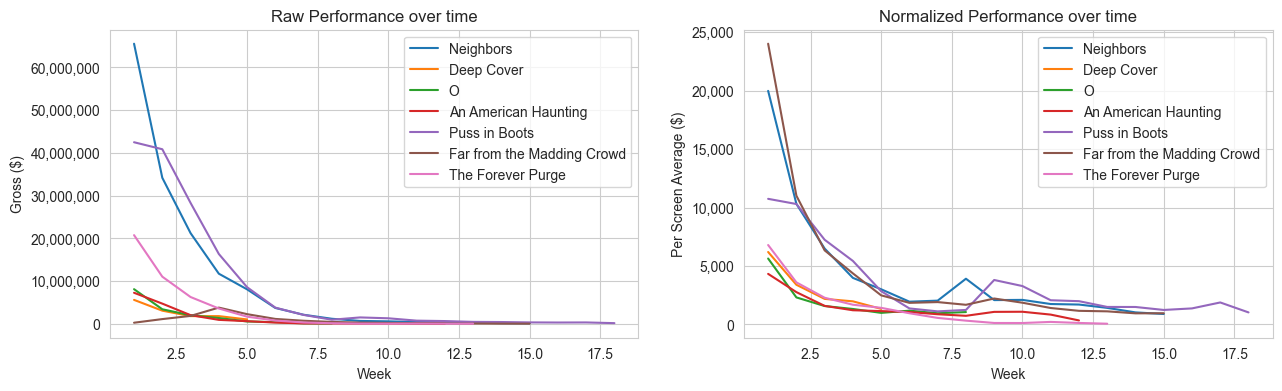

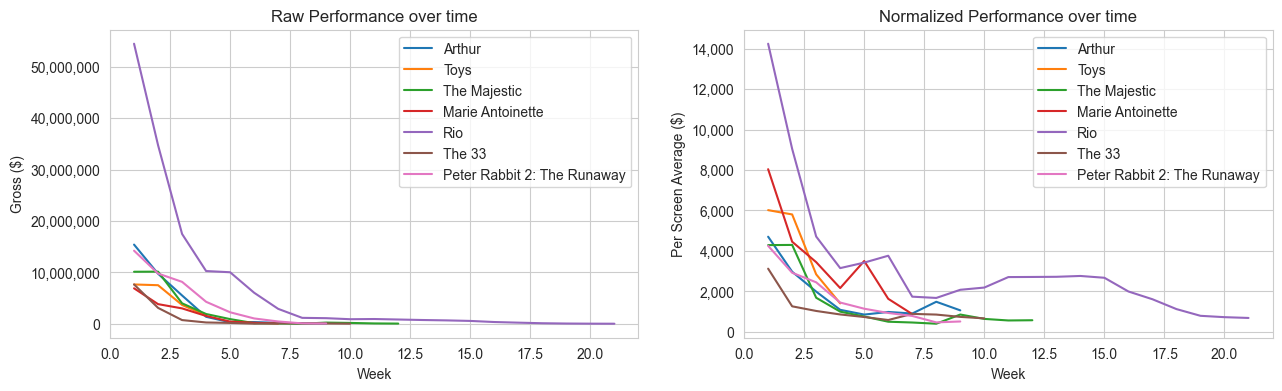

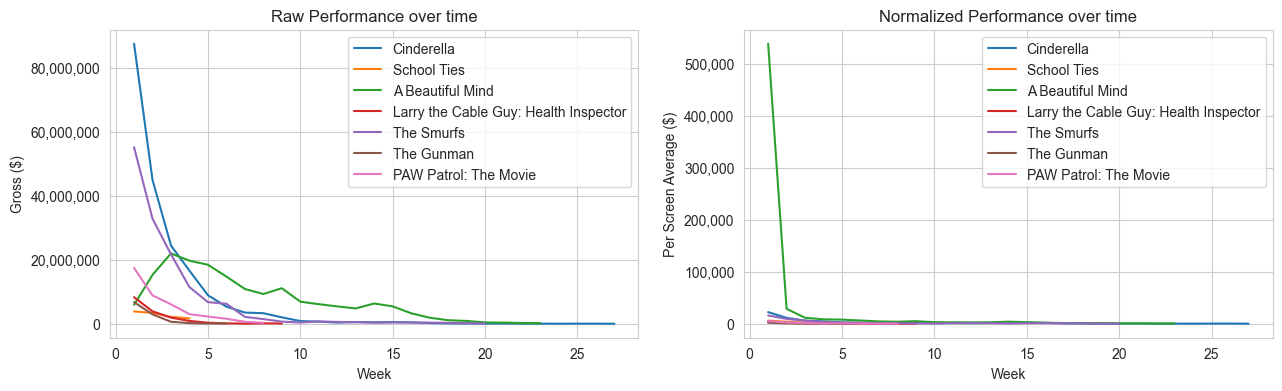

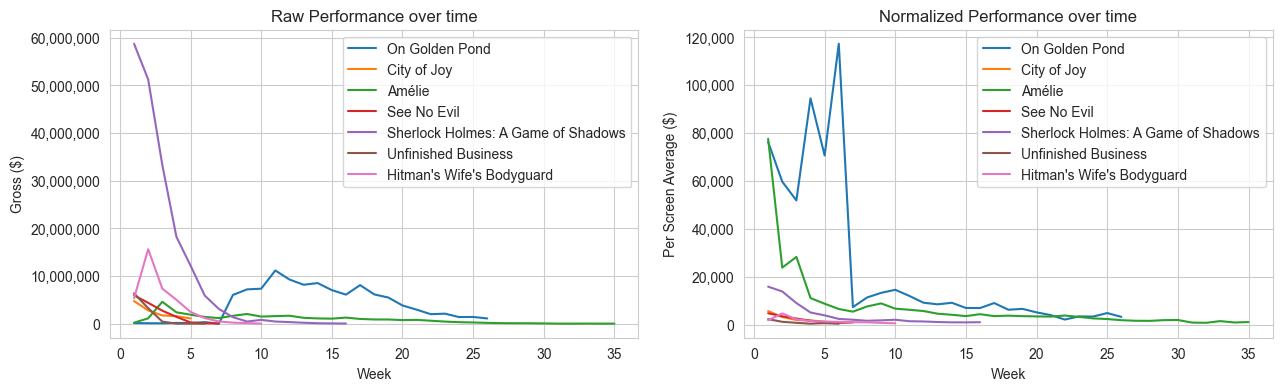

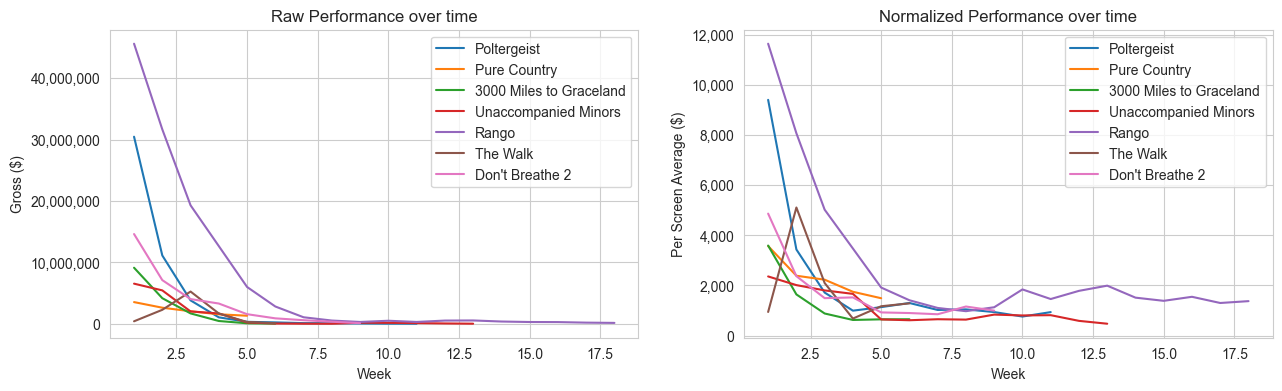

In [4]:
start = 10
for start in range(start, start+5, 1):
    figs, axs = plt.subplots(1, 2, figsize = (15,4))
    for title in list(boxOffice)[start::700]:
        axs[1].plot(boxOffice[title].Week, boxOffice[title].Avg, label=title)
        axs[0].plot(boxOffice[title].Week, boxOffice[title].Weekly, label=title)
    for i in range(2):  
        axs[i].set_xlabel('Week')
        axs[i].legend()
        axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
    axs[1].set_title('Normalized Performance over time')
    axs[0].set_title('Raw Performance over time')
    axs[1].set_ylabel('Per Screen Average ($)')
    axs[0].set_ylabel('Gross ($)')

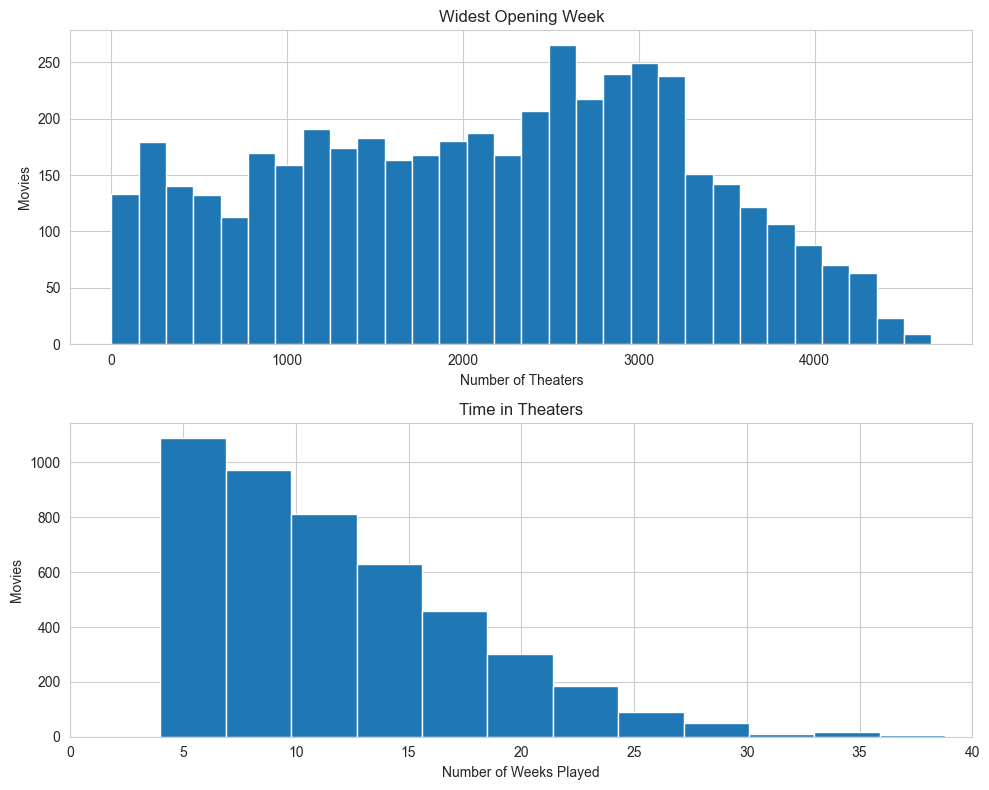

In [5]:
maxTheaters = []
numWeeks = []
for title in boxOffice.keys():
    maxTheaters.append(max(boxOffice[title].Theaters))
    numWeeks.append(int(max(boxOffice[title].Week)))

figs, axs = plt.subplots(2, figsize=(10, 8))
axs[0].hist(maxTheaters, bins=30)
axs[0].set_title('Widest Opening Week')
# ax.xlim([0, 50])
axs[0].set_xlabel('Number of Theaters')
axs[0].set_ylabel('Movies')

axs[1].hist(numWeeks, bins=60)

# Ticks placed at the center of the bins.
axs[1].set_title('Time in Theaters')
axs[1].set_xlim([0, 40])
# axs[1].set_xticks(np.arange(1, 300, 30))
# axs[1].set_xticklabels(np.arange(1, 300, 30))
axs[1].set_xlabel('Number of Weeks Played')
axs[1].set_ylabel('Movies')
figs.tight_layout()

Now I will attempt to compute an "average" decay time series across all the movies

C:\Users\viper\AppData\Local\Temp\ipykernel_39432\1298181395.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


[Text(0, -2500000.0, '-2,500,000'),
 Text(0, 0.0, '0'),
 Text(0, 2500000.0, '2,500,000'),
 Text(0, 5000000.0, '5,000,000'),
 Text(0, 7500000.0, '7,500,000'),
 Text(0, 10000000.0, '10,000,000'),
 Text(0, 12500000.0, '12,500,000'),
 Text(0, 15000000.0, '15,000,000'),
 Text(0, 17500000.0, '17,500,000'),
 Text(0, 20000000.0, '20,000,000')]

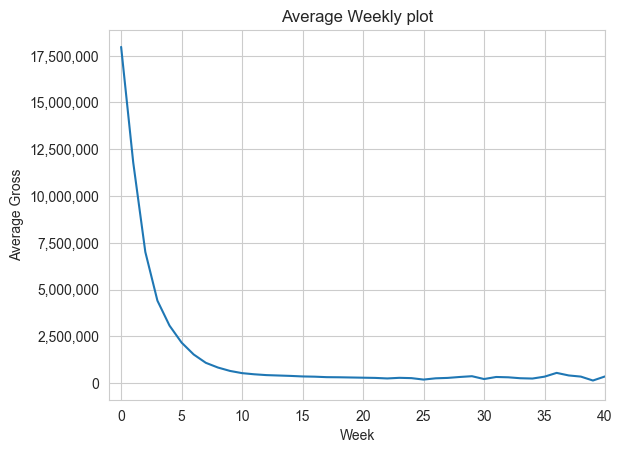

In [6]:
totalDecay = np.zeros(max(numWeeks))
moviesWithWeek = np.zeros(max(numWeeks))
for title in list(boxOffice)[2:]:
    for week in boxOffice[title].Week.index:
        totalDecay[boxOffice[title].Week.iloc[week]-1]+= boxOffice[title].Weekly.iloc[week]
        moviesWithWeek[boxOffice[title].Week.iloc[week]-1]+=1

averageDecay = totalDecay
for i in range(len(totalDecay)):
    if totalDecay[i]!=0:
        averageDecay[i] = totalDecay[i]/moviesWithWeek[i]

fig, ax = plt.subplots()
ax.plot(averageDecay)
ax.set_xlim([-1, 40])
ax.set_xlabel('Week')
ax.set_ylabel('Average Gross')
ax.set_title('Average Weekly plot')
# ax.plot(1000*moviesWithWeek)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Computing the "Multiplier" (Naïvely)
This quantifies how much of a movie's total gross comes from it's first initial run. Here I am naively computing it as the total gross divided by the gross from the first N weeks in theates. Thus, movies with longer "leg"s have higher multipliers meaning they made a significant portion of their total after the initial run. We theorize these higher multipliers will correlate with good reviews

Text(0.5, 0.98, 'Multiplier distribution for openings of various lengths')

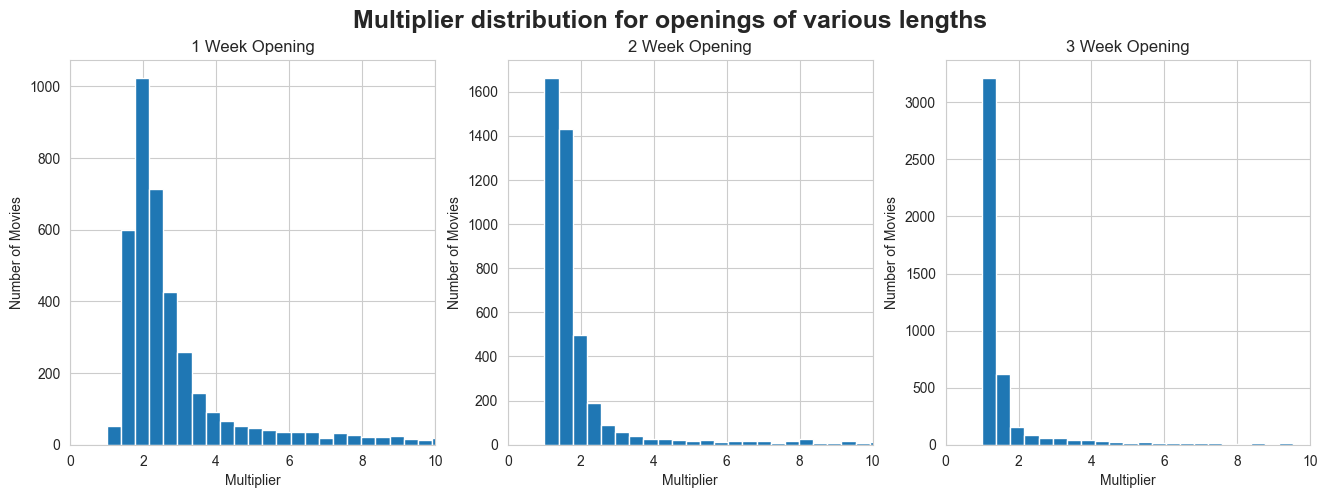

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
multipliers = [{}, {}, {}]
i=0
for weekThreshold in range(1, 4):
    multipliers[i] = boxOffice.copy()
    for title in boxOffice:
        opening = sum(boxOffice[title].Weekly.iloc[0:weekThreshold].values)
        total = sum(boxOffice[title].Weekly.values)
        multiplier = total/opening
        # if multiplier>5:
        #     print(title)
        #     print(multiplier)
        multipliers[i][title] = multiplier

    axs[i].hist(multipliers[weekThreshold-1].values(), bins=np.linspace(1, 20, 50))
    axs[i].set_xlim([0, 10])
    axs[i].set_title(str(weekThreshold)+" Week Opening")
    axs[i].set_xlabel("Multiplier")
    axs[i].set_ylabel("Number of Movies")
    i+=1
fig.suptitle("Multiplier distribution for openings of various lengths", fontsize=18, fontweight="bold")

# Computing the multiplier (intelligently!?)

Now let's try and take into account the fact that some movies open in only a few theaters to start with and are thus guaranteed to have small "openings". Thus we will attempt to define the opening week as the cumulative total from the initial weeks up to the first week in which it was open in a number of theaters greater than a certain fraction of the widest week (week it played in the most theaters)

Text(0.5, 0.98, 'Multiplier distribution for openings of various relative widths')

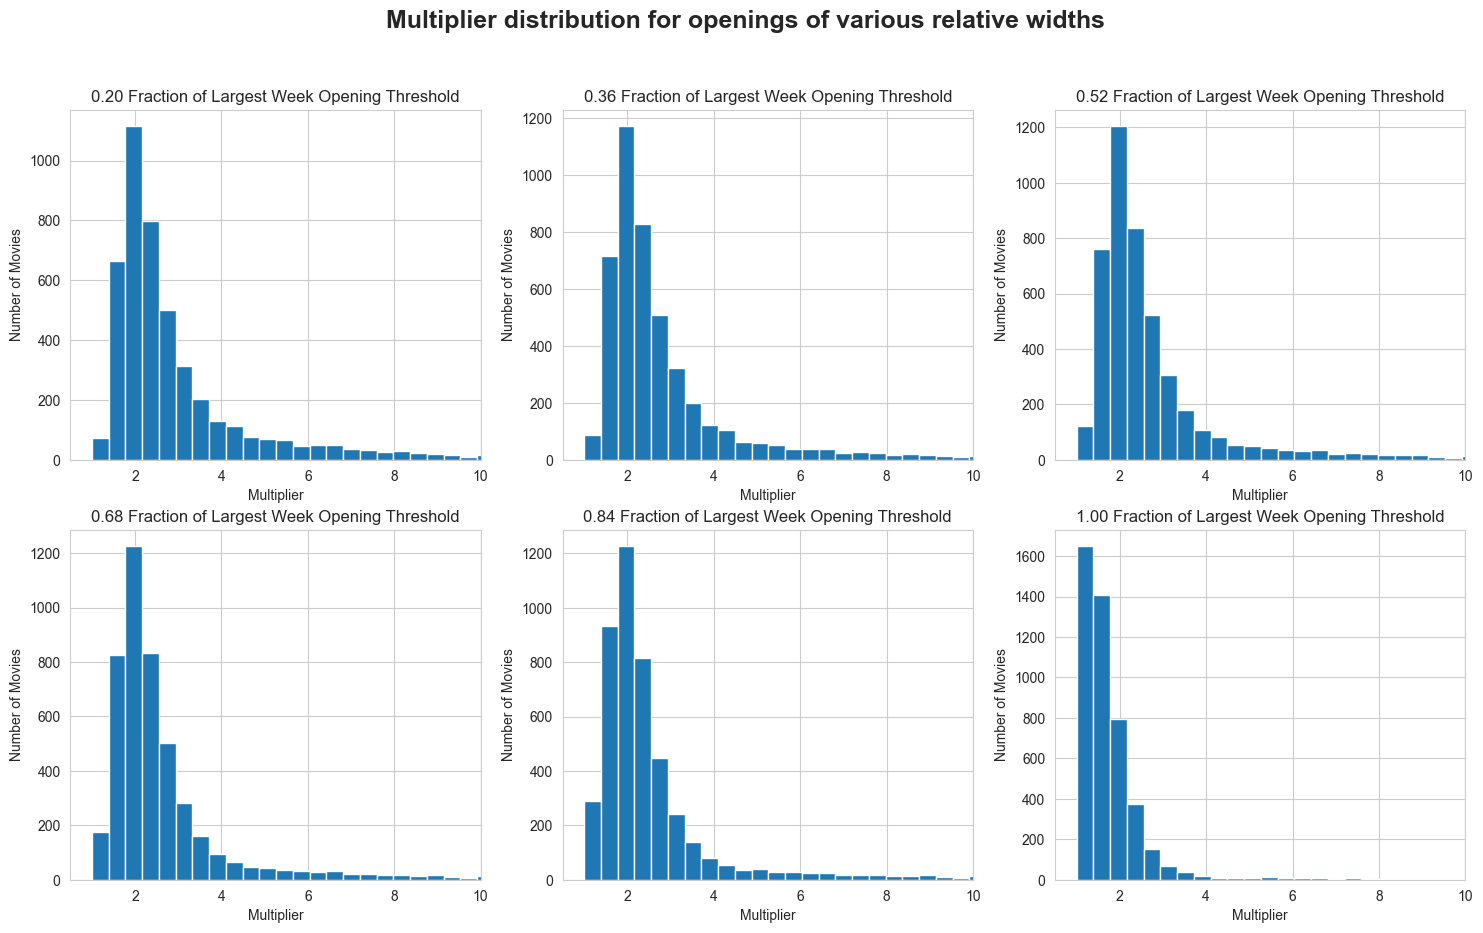

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(18,10))
i=0
for threshold in np.linspace(0.2, 1, 6):
    smartMultipliers = {}
    for title in boxOffice:
        widestWeek = max(boxOffice[title].Theaters)
        startingWeek = 0
        currentWeek = 0
        for week in boxOffice[title].Theaters>=threshold*widestWeek:
            if week:
                startingWeek = currentWeek+1
                break
            currentWeek+=1
        opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
        total = sum(boxOffice[title].Weekly.values)
        multiplier = total/opening
            
        # if multiplier>5:
        #     print(title)
        #     print(multiplier)
        smartMultipliers[title] = multiplier
    axs[i//3, i%3].hist(smartMultipliers.values(), bins=np.linspace(1, 20, 50))
    axs[i//3, i%3].set_xlim([0.5, 10])
    axs[i//3, i%3].set_title('%.2f Fraction of Largest Week Opening Threshold' %threshold)
    axs[i//3, i%3].set_xlabel("Multiplier")
    axs[i//3, i%3].set_ylabel("Number of Movies")
    i+=1

fig.suptitle("Multiplier distribution for openings of various relative widths", fontsize=18, fontweight="bold")

It seems like setting the opening threshold high does lower the number of high multiplier outliers, but the vast majority still fit follow a pretty predictable distribution peaking around 2. Let's look at some outlier movies with high multipliers from this metric just for fun.

C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2797593055.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2797593055.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2797593055.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_39432\2797593055.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

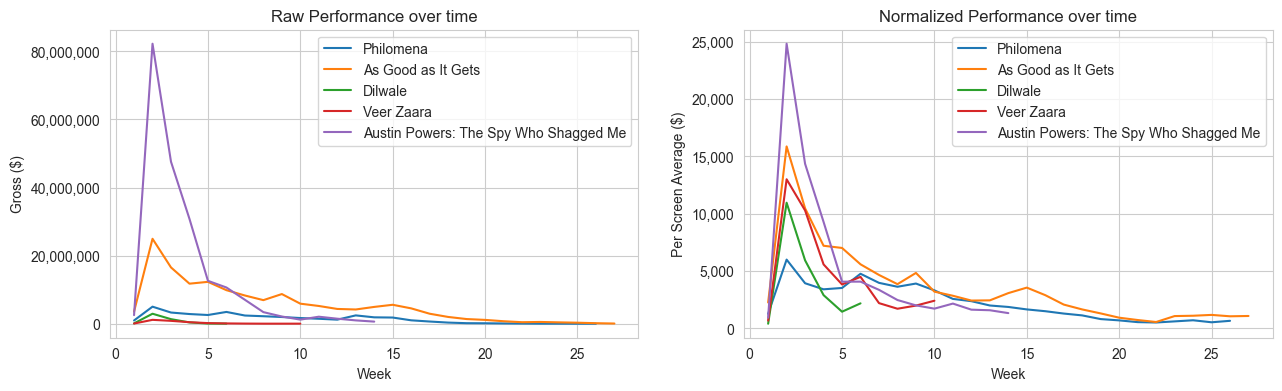

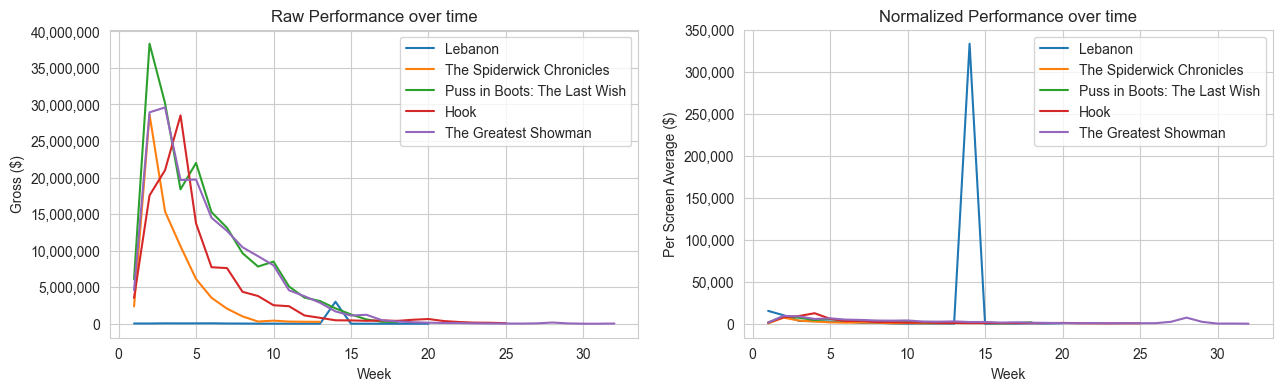

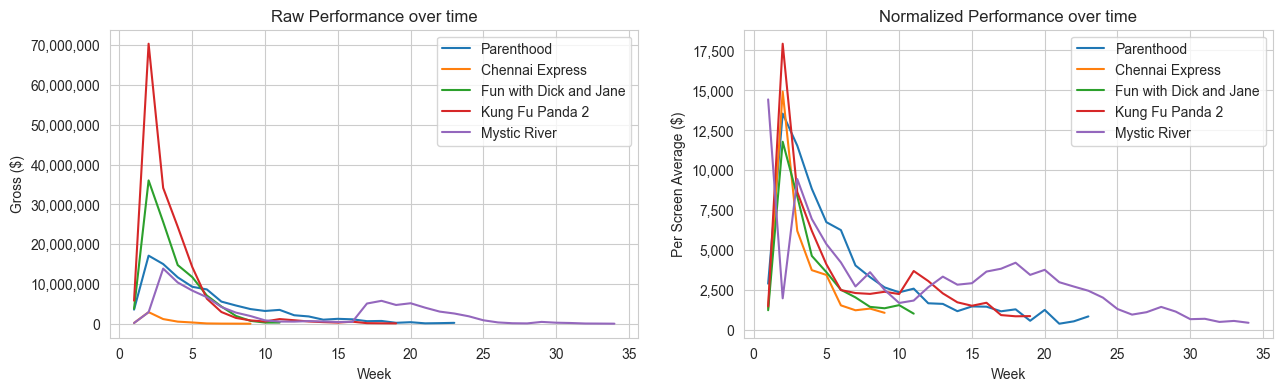

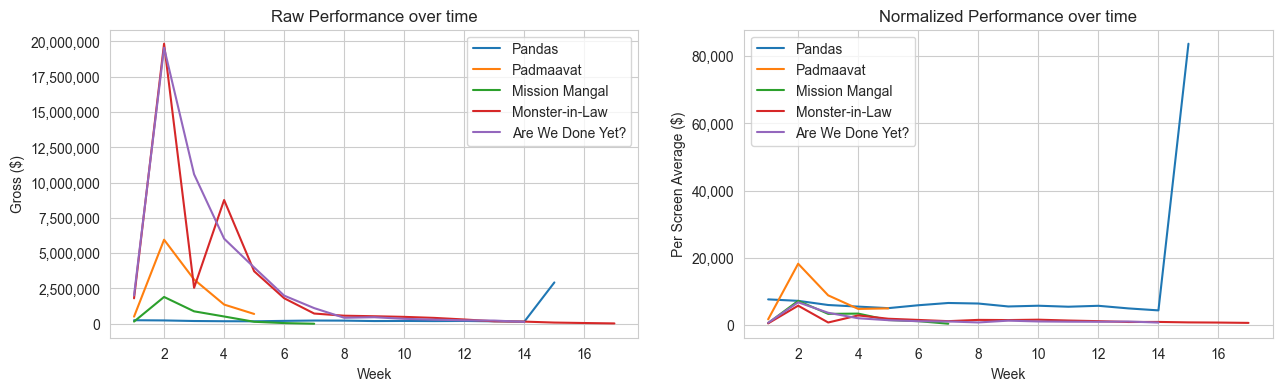

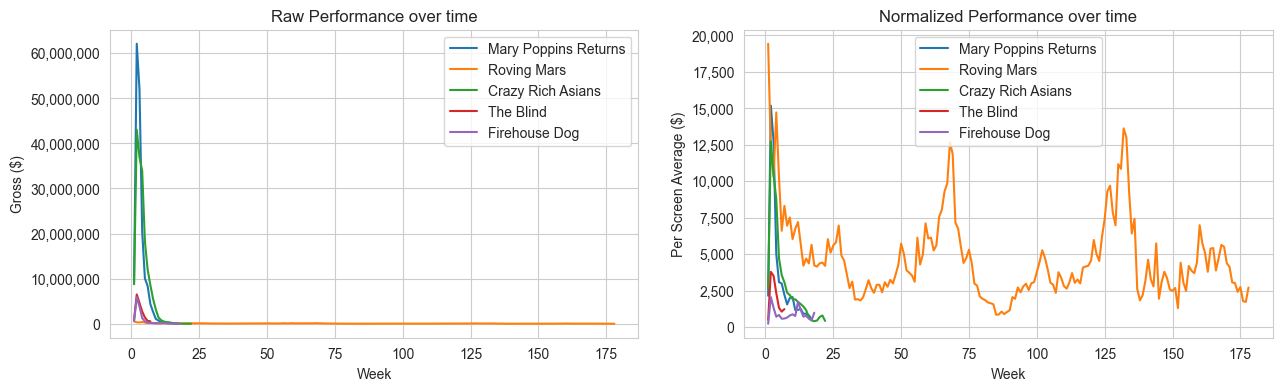

In [9]:
finalMultiplier = {}
finalthreshold = 0.6
for title in boxOffice:
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    for week in boxOffice[title].Theaters>=finalthreshold*widestWeek:
        if week:
            startingWeek = currentWeek+1
            break
        currentWeek+=1
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
        
    # if multiplier>5:
    #     print(title)
    #     print(multiplier)
    finalMultiplier[title] = multiplier
sortedMultipliers = dict(sorted(finalMultiplier.items(), key=lambda item: item[1]))
list(sortedMultipliers.keys())[-10:-5]
start = 1
for set in range(0, 5, 1):
    figs, axs = plt.subplots(1, 2, figsize = (15,4))
    for title in list(sortedMultipliers.keys())[-5*set-6:-set*5-1]:
        axs[1].plot(boxOffice[title].Week, boxOffice[title].Avg, label=title)
        axs[0].plot(boxOffice[title].Week, boxOffice[title].Weekly, label=title)
    for i in range(2):  
        axs[i].set_xlabel('Week')
        axs[i].legend()
        axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
    axs[1].set_title('Normalized Performance over time')
    axs[0].set_title('Raw Performance over time')
    axs[1].set_ylabel('Per Screen Average ($)')
    axs[0].set_ylabel('Gross ($)')